Features selecionadas: ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']
Melhores parâmetros (10-Fold CV): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Acurácia média (LOO): 0.9367 ± 0.2434

Relatório de Classificação:
              precision    recall  f1-score   support

     Maligno       0.97      0.93      0.95       212
     Benigno       0.96      0.98      0.97       357

    accuracy                           0.96       569
   macro avg       0.97      0.96      0.96       569
weighted avg       0.96      0.96      0.96       569

Acurácia Total: 0.9648506151142355
ROC AUC: 0.9956265525077955


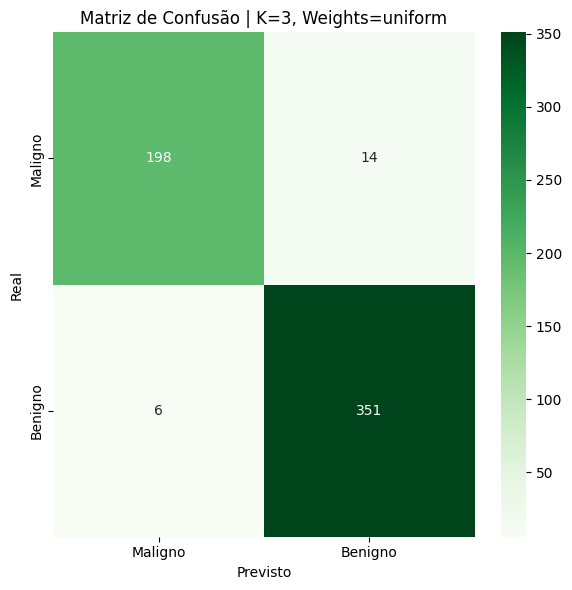

In [3]:
# === ETAPA 1: Importação e Parametrização ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Parâmetros
random_seed = 42
palette = ['limegreen', 'indianred']

np.random.seed(random_seed)

# === ETAPA 2: Carregar e Preparar os Dados ===
dados = load_breast_cancer()
df = pd.DataFrame(dados.data, columns=dados.feature_names)
df['target'] = dados.target

# Seleção estatística inicial de features com ANOVA F-value
k_best = SelectKBest(score_func=f_classif, k=15)
X_kbest = k_best.fit_transform(df.drop(columns='target'), df['target'])
selected_features = df.drop(columns='target').columns[k_best.get_support()].tolist()

# Visualizar features selecionadas
print("Features selecionadas:", selected_features)

# === ETAPA 3: Padronização ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kbest)
y = df['target'].values

# === ETAPA 4: Validação Cruzada Estratificada (10-fold) com Busca de Hiperparâmetros ===
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
param_grid = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_scaled, y)

melhor_knn = grid.best_estimator_
print("Melhores parâmetros (10-Fold CV):", grid.best_params_)

# === ETAPA 5: Validação com Leave-One-Out (LOO) ===
loo = LeaveOneOut()
loo_scores = cross_val_score(melhor_knn, X_scaled, y, cv=loo, scoring='accuracy', n_jobs=-1)
print(f"Acurácia média (LOO): {loo_scores.mean():.4f} ± {loo_scores.std():.4f}")

# === ETAPA 6: Avaliação Final em Todos os Dados ===
y_pred = melhor_knn.predict(X_scaled)
y_pred_proba = melhor_knn.predict_proba(X_scaled)[:, 1]

print("\nRelatório de Classificação:")
print(classification_report(y, y_pred, target_names=['Maligno', 'Benigno']))
print("Acurácia Total:", accuracy_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_pred_proba))

# === ETAPA 7: Matriz de Confusão ===
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d', xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão | K={melhor_knn.n_neighbors}, Weights={melhor_knn.weights}')
plt.tight_layout()
plt.show()
